### Runtime Toggles

In [515]:
checkpoint_flag = 0
append_flag = True
print_flag = False

In [516]:
!pip install scikit-surprise --q

In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from collections import defaultdict

In [518]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [519]:
import os

os.chdir("/content/drive/MyDrive/Hunch/data")

### Loading the data

In [520]:
events_data = pd.read_csv("Train_data.csv")
poll_features = pd.read_csv("poll_question_features.csv")

### Preprocessing & Handling

#### App Events

**Investigating user_code**

In [521]:
events_data[['user_code','poll_code']].nunique()

user_code    4499
poll_code     893
dtype: int64

In [522]:
events_data['user_code_new'] = events_data.user_code.apply(lambda x : x.split("_")[-1])
# some users user_code is missing and the value is unknown_user and such entries are being flagged as -1
events_data.loc[~events_data.user_code_new.str.isnumeric(),'user_code_new'] = -1
events_data['user_code_new'] = events_data['user_code_new'].astype(int)
events_data['user_code_new'].max()

4835

In [523]:

# some users dont have any events data
# Out of total users of 4835, we have events data for 4499 users


**Investigating poll_code**

In [524]:
events_data[['user_code','poll_code']].nunique()

user_code    4499
poll_code     893
dtype: int64

In [525]:
events_data['poll_code_new'] = events_data.poll_code.apply(lambda x : x.split("_")[-1])
# some users poll_code is missing and the value is unknown_user and such entries are being flagged as -1
events_data.loc[~events_data.poll_code_new.str.isnumeric(),'poll_code_new'] = -1
events_data['poll_code_new'] = events_data['poll_code_new'].astype(int)
events_data['poll_code_new'].max()

920

In [526]:

# some users dont have any events data
# Out of total polls of 920, we have events data for 893 polls/questions


**Investigating event type**

In [527]:
events_data.event.value_counts()

Impression        138739
Polls Answered    102950
Expand              5632
Session             3421
Shares               439
Name: event, dtype: int64

| Interaction Type | Description                                                                                              |
|------------------|----------------------------------------------------------------------------------------------------------|
| Session            | One login - logout                                               |
| Impression       | This indicates that the user only viewed the poll but did not participate in it                           |
| Expand           | This indicates that the user expanded the post to view the comments                                      |
| Shares           | This indicates that the user shared the post                                                              |
| Polls Answered   | Indicates that the user participated in the poll by voting for the option mentioned in the poll_option_id column |



**Investigating Event type - Session**

In [528]:
events_data[events_data.event=='Session'].poll_code_new.value_counts()

-1    3421
Name: poll_code_new, dtype: int64

In [529]:
(events_data.poll_code=='unknown_poll').value_counts()

False    247760
True       3421
Name: poll_code, dtype: int64

In [530]:
## All events that are of type session, the poll_code is unknown_poll,
## which is genuine,
## as these events are login-logoff events

**Investigating Event type - Impression, Expand, Session, Shares**

In [531]:
pd.set_option("display.max_rows",200)

In [532]:
events_data[

    #getting single user data
    (events_data.user_code.isin(events_data.sample(1).user_code)) &

    #getting relevant events
    (events_data.event.isin(['Impression','Expand','Session','Shares']))

].sort_values(['user_code','poll_code','event'])[['createdAt','user_code','poll_code','event','id_code']]

,createdAt,user_code,poll_code,event,id_code
145146,2023-01-24 15:12:09 UTC,user_3170,poll_103,Impression,option_179329
145139,2023-01-24 15:10:16 UTC,user_3170,poll_106,Impression,option_179322
145137,2023-01-24 15:09:50 UTC,user_3170,poll_109,Impression,option_179320
145143,2023-01-24 15:11:21 UTC,user_3170,poll_11,Impression,option_179326
145191,2023-01-24 15:22:59 UTC,user_3170,poll_113,Impression,option_179374
145188,2023-01-24 15:22:14 UTC,user_3170,poll_114,Impression,option_179371
145165,2023-01-24 15:17:45 UTC,user_3170,poll_116,Impression,option_179348
145174,2023-01-24 15:19:45 UTC,user_3170,poll_118,Impression,option_179357
145206,2023-01-24 15:28:48 UTC,user_3170,poll_120,Impression,option_179389
145193,2023-01-24 15:23:20 UTC,user_3170,poll_125,Impression,option_179376


In [533]:
events_data['user_poll_pair'] = events_data.user_code_new.astype(str) + "_" + events_data.poll_code_new.astype(str)

*Shares* - checking if all shares has impressions or not

In [534]:
events_data[events_data.event=='Shares'].user_poll_pair.nunique()

342

In [535]:
events_data[events_data.event=='Shares'].user_poll_pair.drop_duplicates().isin(events_data[events_data.event=='Impression'].user_poll_pair).value_counts()


True     322
False     20
Name: user_poll_pair, dtype: int64

In [536]:
append1 = events_data[events_data.event=='Shares'].drop_duplicates('user_poll_pair',keep='first')[
    ~ events_data[events_data.event=='Shares'].user_poll_pair.drop_duplicates().isin(events_data[events_data.event=='Impression'].user_poll_pair)
]

In [537]:
append1.event = 'Impression'

In [538]:
append1.shape

(20, 13)

*Expand* - checking if all Expands has impressions or not

In [539]:
events_data[events_data.event=='Expand'].user_poll_pair.nunique()

4642

In [540]:
events_data[events_data.event=='Expand'].user_poll_pair.drop_duplicates().isin(events_data[events_data.event=='Impression'].user_poll_pair).value_counts()

True     4476
False     166
Name: user_poll_pair, dtype: int64

In [541]:
append2 = events_data[events_data.event=='Expand'].drop_duplicates('user_poll_pair',keep='first')[
    ~ events_data[events_data.event=='Expand'].user_poll_pair.drop_duplicates().isin(events_data[events_data.event=='Impression'].user_poll_pair)
]

In [542]:
append2.event = 'Impression'

In [543]:
append2.shape

(166, 13)

*Polls Answered* - checking if all shares has impressions or not

In [544]:
events_data[events_data.event=='Polls Answered'].user_poll_pair.nunique()

102916

In [545]:
events_data[events_data.event=='Polls Answered'].user_poll_pair.drop_duplicates().isin(events_data[events_data.event=='Impression'].user_poll_pair).value_counts()

True     83751
False    19165
Name: user_poll_pair, dtype: int64

In [546]:
append3 = events_data[events_data.event=='Polls Answered'].drop_duplicates('user_poll_pair',keep='first')[
    ~ events_data[events_data.event=='Polls Answered'].user_poll_pair.drop_duplicates().isin(events_data[events_data.event=='Impression'].user_poll_pair)
]

In [547]:
append3.event = 'Impression'

In [548]:
append3.shape

(19165, 13)

In [549]:
if append_flag :
  events_data = pd.concat([events_data,append1,append2,append3],axis=0)

In [550]:
## impression indicates that the user has seen the poll
## after Impression user can Expand, Share or Answer
## A lot of Polls Answered didnt have impression - which was odd, thus events were created

**Investigating id_code**

In [551]:
events_data.id_code

0          option_17106
1          option_17107
2          option_17108
3          option_17109
4          option_17110
              ...      
251143    option_184762
251146    option_185051
251177    option_184768
251178    option_184767
251179    option_184768
Name: id_code, Length: 270532, dtype: object

In [552]:
events_data.id_code.isnull().sum()

0

In [553]:
events_data[events_data.event=="Session"].id_code.isnull().sum()

0

In [554]:
# id_code is not clear, how can a Session have an option_id.
# It makes sense that there is id_code for Polls Answered but having an id_code for any other event is not possible.
# Thus the description doesnt match the data
# we shall ignore the column

#### User Properties / Features :

* 'country'
* 'city_code'
* 'gender'
* 'age'
* 'college_code'

In [555]:
columns = ['country','city_code','gender','age','college_code']

In [556]:
user_features = pd.DataFrame()

for i in columns :

  temp = events_data[['user_code',i]].groupby(['user_code',i]).count().reset_index()

  print(i)

  #checking is same user has multiple entries or not
  print(temp.user_code.nunique(), temp.shape,"\n")

  if i == 'country' :
    user_features = temp
  else :
    user_features = user_features.merge(temp,on='user_code',how='left')

user_features = user_features[user_features.user_code!='unknown_user']

country
4499 (4499, 2) 

city_code
4499 (4499, 2) 

gender
4499 (4500, 2) 

age
2031 (2031, 2) 

college_code
1221 (1221, 2) 



In [557]:
user_features.head()

,user_code,country,city_code,gender,age,college_code
1,user_1,country_1,city_1,male,18.0,NaN
2,user_10,unknown_country,unknown_city,skipped_by_user,NaN,NaN
3,user_100,unknown_country,unknown_city,skipped_by_user,NaN,NaN
4,user_1000,country_1,city_1,skipped_by_user,NaN,NaN
5,user_1001,country_1,city_57,male,21.0,NaN


In [558]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4499 entries, 1 to 4499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_code     4499 non-null   object 
 1   country       4499 non-null   object 
 2   city_code     4499 non-null   object 
 3   gender        4499 non-null   object 
 4   age           2032 non-null   float64
 5   college_code  1222 non-null   object 
dtypes: float64(1), object(5)
memory usage: 246.0+ KB


In [559]:
for i in ['country', 'city_code', 'gender', 'college_code'] :

  #printing value_counts - to estimate null_values vs missing imputations

  temp2 = pd.DataFrame(user_features[i].value_counts())
  temp2 = temp2[temp2[i] > 225]

  #5% of total unique users 4500 = 225
  #logic is minimum bucket size should be 5%

  display(temp2)

,country
country_1,4285


,city_code
city_1,3351
city_18,238


,gender
skipped_by_user,2496
male,1668
female,310


,college_code
Other,494


In [560]:


# most users are from the same country
# most users are from 2 cities, others we will ignore
# age we will have to bucket
# even college code that is significant os others, thus, we will make 2 buckets of college code



In [561]:
user_features.loc[user_features.country != 'country_1', 'country'] = 'Others'

In [562]:
user_features.loc[~user_features.city_code.isin(['city_1','city_18']), 'city_code'] = 'Others'

In [563]:
user_features.loc[~user_features.gender.isin(['male','female','skipped_by_user']), 'gender'] = 'Others'

In [564]:
user_features.loc[user_features.college_code.isin(['Other']), 'college_code']  = 'code_missing_aka_others'
user_features.loc[~user_features.college_code.isin(['Other']), 'college_code']  = 'code_present'
user_features.college_code = user_features.college_code.fillna("skipped")

In [565]:
user_features.age = pd.qcut(user_features.age,3)

In [566]:
user_features

,user_code,country,city_code,gender,age,college_code
1,user_1,country_1,city_1,male,"(-1.001, 19.0]",code_present
2,user_10,Others,Others,skipped_by_user,NaN,code_present
3,user_100,Others,Others,skipped_by_user,NaN,code_present
4,user_1000,country_1,city_1,skipped_by_user,NaN,code_present
5,user_1001,country_1,Others,male,"(19.0, 22.0]",code_present
...,...,...,...,...,...,...
4495,user_995,country_1,city_1,skipped_by_user,NaN,code_present
4496,user_996,country_1,city_1,male,"(-1.001, 19.0]",code_present
4497,user_997,country_1,Others,female,"(22.0, 61.0]",code_present
4498,user_998,country_1,city_1,male,"(-1.001, 19.0]",code_present


#### Poll Features

In [567]:
poll_features.poll_code.nunique(),poll_features.shape[0]

(707, 807)

In [568]:
temp = pd.DataFrame(poll_features.poll_code.value_counts()).reset_index()

list_of_double_cat = temp[temp.poll_code>=2]['index'].values

print("count of duplicates - ",len(list_of_double_cat),"\n\n")

poll_features[poll_features.poll_code.isin(list_of_double_cat)]

count of duplicates -  60 




,poll_code,displayType,categories
9,poll_22,text,Random
10,poll_22,text,Lifestyle
16,poll_33,text,Random
17,poll_33,text,Dating and Relationship
44,poll_97,text,Random
45,poll_97,text,Other
48,poll_101,text,Random
49,poll_101,text,Other
52,poll_107,text,Random
53,poll_107,text,Would You Rather


In [569]:
poll_features[poll_features.poll_code.isin(list_of_double_cat)].categories.value_counts()

Random                     60
Other                      23
Dating and Relationship    16
Lifestyle                   5
Would You Rather            5
Hypothetical                5
Internet                    3
Philosophy and Religion     2
Trivia                      1
Name: categories, dtype: int64

In [570]:
# Based on manual investigation - random seems like an erroneous entry for these 60 polls

In [571]:
poll_features = poll_features[~((poll_features.poll_code.isin(list_of_double_cat)) & (poll_features.categories=='Random'))]

In [572]:
# checking for doule entries
temp = pd.DataFrame(poll_features.poll_code.value_counts()).reset_index()
temp[temp.poll_code>=2]['index']

Series([], Name: index, dtype: object)

In [573]:
poll_features

,poll_code,displayType,categories
0,poll_3,text,Movies and TV
1,poll_4,text,Other
2,poll_7,text,Food and Drinks
3,poll_11,text,Dating and Relationship
4,poll_12,text,Would You Rather
...,...,...,...
801,poll_698,text,Dating and Relationship
802,poll_701,text,Other
804,poll_702,text,Other
805,poll_703,text,Internet


### Data Preparation

In [574]:
events_data_save = events_data.copy()

In [575]:
# events_data = events_data_save.copy()

In [576]:
#remove sessions
events_data = events_data[events_data.event!='Session']

#remove unknown users
events_data = events_data[events_data.user_code!='unknown_user']

In [577]:
#giving a score to each user
events_data['event_score'] = events_data.event.map({
    'Impression' : 0,
    'Expand' : 0,
    'Polls Answered'  : 1,
    'Shares' : 0
})

<ipython-input-577-8a18c40dfaba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_data['event_score'] = events_data.event.map({


In [578]:
events_data['user_code_new'] = events_data.user_code.apply(lambda x : x.split("_")[-1]).astype(int)
events_data['poll_code_new'] = events_data.poll_code.apply(lambda x : x.split("_")[-1]).astype(int)

In [579]:
ratings = events_data.groupby(['user_code_new','poll_code_new','event']).event_score.max().reset_index()
ratings = ratings.groupby(['user_code_new','poll_code_new']).event_score.sum().reset_index()

In [580]:
# events_data[(events_data.user_code_new==20) & (events_data.poll_code_new==273)]

In [581]:
ratings.shape

(130384, 3)

In [582]:
ratings.event_score.value_counts()

1    102916
0     27468
Name: event_score, dtype: int64

In [583]:
pd.cut(ratings.event_score,bins=[-1,1,3,9]).value_counts(normalize=True)

(-1, 1]    1.0
(1, 3]     0.0
(3, 9]     0.0
Name: event_score, dtype: float64

In [584]:
# temp = pd.DataFrame(ratings.user_code_new.value_counts())
# users_to_consider = temp[temp.user_code_new > 10].index
# print(len(users_to_consider))
# ratings = ratings[ratings.user_code_new.isin(users_to_consider)]

In [585]:
ratings

,user_code_new,poll_code_new,event_score
0,1,21,1
1,1,41,1
2,1,44,1
3,1,47,1
4,1,49,1
...,...,...,...
130379,4831,288,1
130380,4832,121,1
130381,4833,288,1
130382,4834,194,1


In [586]:
# stratified to keep the distribution of movie ratings the same in train and test datasets.
train, test = train_test_split(
    ratings,
    test_size=0.1,
    stratify=pd.qcut(ratings.event_score,q=5,duplicates='drop'),
    random_state=32
)

In [587]:
ratings.to_csv("ratings.csv",index=False)

### Exploratory Data Analysis

In [588]:
# events_data_save

In [589]:
# events_data.createdAt = pd.to_datetime(events_data.createdAt)

In [590]:
events_data.head(2)

,createdAt,user_code,poll_code,id_code,event,country,city_code,gender,age,college_code,user_code_new,poll_code_new,user_poll_pair,event_score
0,2022-12-29 18:30:10 UTC,user_2847,poll_27,option_17106,Impression,country_1,city_1,skipped_by_user,NaN,NaN,2847,27,2847_27,0
1,2022-12-29 18:30:28 UTC,user_2847,poll_220,option_17107,Impression,country_1,city_1,skipped_by_user,NaN,NaN,2847,220,2847_220,0


In [591]:
event_list = ['Impression',
'Polls Answered',
# 'Expand',
'Shares']

In [592]:
eda = events_data[events_data.event.isin(event_list)].groupby(['user_code_new','poll_code_new','event'])[['createdAt']].count().reset_index().rename(columns={'createdAt':'event_count'})

In [593]:
eda2 = eda.pivot(index=['user_code_new','poll_code_new'],columns='event',values='event_count').reset_index()

In [594]:
eda2.head(2)

event,user_code_new,poll_code_new,Impression,Polls Answered,Shares
0,1,21,1.0,1.0,NaN
1,1,41,1.0,1.0,NaN


In [595]:
eda2 = eda2.fillna(0)

In [596]:
eda3 = eda2.groupby('user_code_new')[['Impression','Polls Answered','Shares']].sum()

In [597]:
eda3['ratio1'] = eda3['Polls Answered'] / eda3['Impression']
eda3['ratio2'] = eda3['Shares'] / eda3['Impression']

In [598]:
eda3['poll_answered_ratio_bucket'] = pd.cut(eda3.ratio1,bins=[0,0.25,0.5,0.75,1])
eda3['shares_ratio_bucket'] = pd.cut(eda3.ratio2,bins=[0,0.25,0.5,0.75,1])

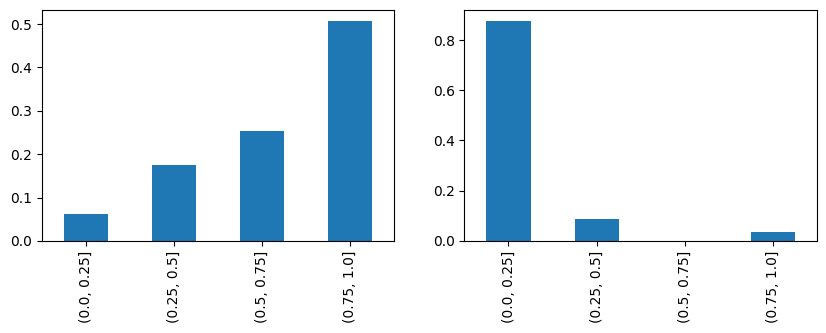

In [599]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
eda3.poll_answered_ratio_bucket.value_counts(sort=False,normalize=True).plot.bar()

plt.subplot(1,2,2)
eda3.shares_ratio_bucket.value_counts(sort=False,normalize=True).plot.bar()

plt.show()

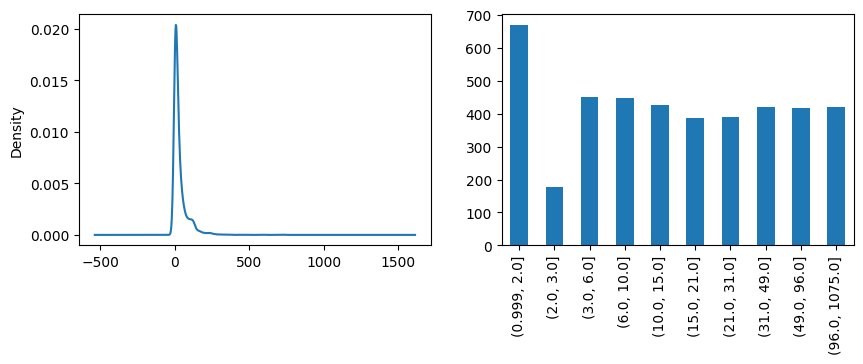

In [600]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
eda2.groupby('user_code_new')['Impression'].sum().plot(kind='kde')

plt.subplot(1,2,2)
pd.qcut(eda2.groupby('user_code_new')['Impression'].sum(),q=10).value_counts(sort=False).plot.bar()

plt.show()

In [601]:
eda4 = eda2.groupby('poll_code_new')[['Impression','Polls Answered','Shares']].sum()

In [602]:
eda4.head()

event,Impression,Polls Answered,Shares
poll_code_new,,,
1,245.0,192.0,0.0
2,694.0,480.0,3.0
3,89.0,1.0,2.0
4,215.0,177.0,0.0
5,147.0,96.0,0.0


In [603]:
eda4['ratio1'] = eda4['Polls Answered'] / eda4['Impression']
eda4['ratio2'] = eda4['Shares'] / eda4['Impression']

In [604]:
eda4['user_answered_ratio_bucket'] = pd.cut(eda4.ratio1,bins=[0,0.25,0.5,0.75,1])
eda4['shares_ratio_bucket'] = pd.cut(eda4.ratio2,bins=[0,0.25,0.5,0.75,1])

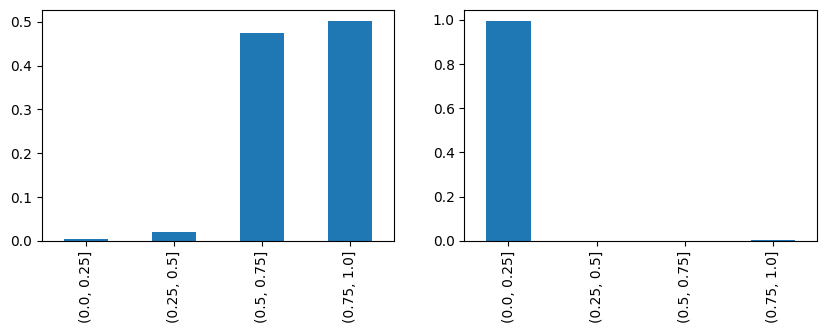

In [605]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
eda4.user_answered_ratio_bucket.value_counts(sort=False,normalize=True).plot.bar()

plt.subplot(1,2,2)
eda4.shares_ratio_bucket.value_counts(sort=False,normalize=True).plot.bar()

plt.show()

### Recommendation Engine

In [606]:
result_dict=dict()

#### Metrics

In [607]:
metrics_dict = dict()

In [608]:
def mean_absolute_error_value(test,predictions) :
    """
    Calculate Mean Absolute Error (MAE).
    """
    test = test.merge(predictions,on=('user_code_new','poll_code_new'),how='inner')
    return mean_absolute_error(test['event_score'], test['predicted'])

def root_mean_squared_error_value(test,predictions):
    """
    Calculate Root Mean Squared Error (RMSE).
    """
    test = test.merge(predictions,on=('user_code_new','poll_code_new'),how='inner')
    return np.sqrt(mean_squared_error(test['event_score'], test['predicted']))

def precision_at_n(top_n, test, n=50):
    """
    Calculate Precision at N.
    """
    merged_df = pd.merge(top_n, test, on=['user_code_new', 'poll_code_new'], how='inner')
    return len(merged_df) / top_n.shape[0] if top_n.shape[0] > 0 else 0

def recall_at_n(top_n, test, n=50):
    """
    Calculate Recall at N.
    """
    merged_df = pd.merge(top_n, test, on=['user_code_new', 'poll_code_new'], how='inner')
    return len(merged_df) / len(test) if len(test) > 0 else 0

def f1_score_at_n(top_n, test, n=50):
    """
    Calculate F1 Score at N.
    """
    precision = precision_at_n(top_n, test, n)
    recall = recall_at_n(top_n, test, n)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def mean_reciprocal_rank(top_n, test):
    """
    Calculate Mean Reciprocal Rank (MRR).
    """
    top_n['n_rank'] = top_n.groupby('user_code_new')['predicted'].rank(ascending=False)
    merged_df = pd.merge(top_n, test, on=['user_code_new', 'poll_code_new'], how='inner')
    merged_df['rank'] = merged_df.groupby('user_code_new')['predicted'].rank(ascending=False)
    reciprocal_rank = 1 / merged_df[merged_df['rank'] == 1]['n_rank']
    return np.mean(reciprocal_rank) if len(reciprocal_rank) > 0 else 0


def mean_average_precision_at_n(top_n, test, n=50,test_type='CB'):
    """
    Calculate Mean Average Precision (MAP) at N.
    """
    average_precision_list = []
    for _, group in top_n.groupby('user_code_new'):
        relevant_items = set(test[test['user_code_new'] == group['user_code_new'].iloc[0]]['poll_code_new'].values)
        precision_at_k_list = []
        cumulative_precision = 0
        for i, item_id in enumerate(group['poll_code_new']):
            if item_id in relevant_items:
                cumulative_precision += 1
                precision_at_k_list.append(cumulative_precision / (i + 1))
        if precision_at_k_list:
            average_precision_list.append(np.mean(precision_at_k_list))
    return np.mean(average_precision_list) if average_precision_list else 0

def ndcg_at_n(top_n, test, n=50):
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG) at N.
    """
    merged_df = pd.merge(top_n, test, on=['user_code_new', 'poll_code_new'], how='inner')
    merged_df['rank'] = merged_df.groupby('user_code_new')['predicted'].rank(ascending=False)
    merged_df['dcg'] = (2 ** merged_df['event_score']) / np.log2(merged_df['rank'] + 1)
    merged_df['idcg'] = (2 ** merged_df['event_score']) / np.log2(merged_df['rank'] + 2)
    ndcg = np.mean(merged_df['dcg'] / merged_df['idcg']) if len(merged_df) > 0 else 0
    return ndcg

#### Content-Based

In [609]:
ratings

,user_code_new,poll_code_new,event_score
0,1,21,1
1,1,41,1
2,1,44,1
3,1,47,1
4,1,49,1
...,...,...,...
130379,4831,288,1
130380,4832,121,1
130381,4833,288,1
130382,4834,194,1


In [610]:
poll_features

,poll_code,displayType,categories
0,poll_3,text,Movies and TV
1,poll_4,text,Other
2,poll_7,text,Food and Drinks
3,poll_11,text,Dating and Relationship
4,poll_12,text,Would You Rather
...,...,...,...
801,poll_698,text,Dating and Relationship
802,poll_701,text,Other
804,poll_702,text,Other
805,poll_703,text,Internet


In [611]:
user_features

,user_code,country,city_code,gender,age,college_code
1,user_1,country_1,city_1,male,"(-1.001, 19.0]",code_present
2,user_10,Others,Others,skipped_by_user,NaN,code_present
3,user_100,Others,Others,skipped_by_user,NaN,code_present
4,user_1000,country_1,city_1,skipped_by_user,NaN,code_present
5,user_1001,country_1,Others,male,"(19.0, 22.0]",code_present
...,...,...,...,...,...,...
4495,user_995,country_1,city_1,skipped_by_user,NaN,code_present
4496,user_996,country_1,city_1,male,"(-1.001, 19.0]",code_present
4497,user_997,country_1,Others,female,"(22.0, 61.0]",code_present
4498,user_998,country_1,city_1,male,"(-1.001, 19.0]",code_present


In [612]:
poll_features

,poll_code,displayType,categories
0,poll_3,text,Movies and TV
1,poll_4,text,Other
2,poll_7,text,Food and Drinks
3,poll_11,text,Dating and Relationship
4,poll_12,text,Would You Rather
...,...,...,...
801,poll_698,text,Dating and Relationship
802,poll_701,text,Other
804,poll_702,text,Other
805,poll_703,text,Internet


In [613]:
if checkpoint_flag==0 :
  save2 = poll_features.copy()

In [614]:
poll_features = save2.copy()

In [615]:
poll_features.head(2)

,poll_code,displayType,categories
0,poll_3,text,Movies and TV
1,poll_4,text,Other


In [616]:
checkpoint_flag = 1
poll_features['poll_code_new'] = poll_features.poll_code.apply(lambda x : str(x).split("_")[-1])

In [617]:
poll_features = poll_features[poll_features['poll_code_new'].str.isnumeric()]

In [618]:
poll_features['poll_code_new'] = poll_features['poll_code_new'].astype(int)

In [619]:
poll_features = pd.concat([poll_features[['poll_code_new']],pd.get_dummies(poll_features[['displayType','categories']])],axis=1)

In [620]:
poll_features

,poll_code_new,displayType_text,categories_Anime,categories_Bollywood,categories_Books And Comics,categories_Campus Musings,categories_Celebrities,categories_City Musings,categories_College Musings,categories_Current Events,...,categories_Other,categories_Philosophy and Religion,categories_Shopping and Finance,categories_Sneakers,categories_Sports,categories_Tech,categories_Technology,categories_Travel and Geography,categories_Trivia,categories_Would You Rather
0,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,698,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
802,701,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
804,702,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
805,703,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [621]:
ratings.poll_code_new.nunique()

890

In [622]:
# find the missing poll_code for polls that dont have features
missing_poll_code = ratings[~ratings.poll_code_new.astype(int).isin(poll_features.poll_code_new.astype(int))].poll_code_new.unique()

In [623]:
len(missing_poll_code)

183

In [624]:
poll_features

,poll_code_new,displayType_text,categories_Anime,categories_Bollywood,categories_Books And Comics,categories_Campus Musings,categories_Celebrities,categories_City Musings,categories_College Musings,categories_Current Events,...,categories_Other,categories_Philosophy and Religion,categories_Shopping and Finance,categories_Sneakers,categories_Sports,categories_Tech,categories_Technology,categories_Travel and Geography,categories_Trivia,categories_Would You Rather
0,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,698,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
802,701,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
804,702,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
805,703,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [625]:
characteristics = list(set(poll_features.columns) - {'poll_code_new'})

In [626]:
user_mapping = ratings.merge(poll_features, on='poll_code_new',how='inner')

In [627]:
for i in characteristics:

  user_mapping[i] = user_mapping[i]*user_mapping['event_score']

In [628]:
user_mapping = user_mapping.groupby('user_code_new')[characteristics].sum()

In [629]:
user_mapping

,categories_Current Events,categories_Would You Rather,categories_Tech,categories_City Musings,categories_Shopping and Finance,categories_Food and Drinks,categories_Internet,categories_Travel and Geography,categories_Trivia,categories_Gaming,...,categories_Bollywood,categories_Technology,categories_Lifestyle,categories_Hobbies,categories_Dating and Relationship,categories_Movies and TV,categories_Language and Names,categories_Hypothetical,displayType_text,categories_College Musings
user_code_new,,,,,,,,,,,,,,,,,,,,,
1,2,0,0,0,0,0,0,0,5,0,...,1,0,0,0,7,1,0,6,36,1
2,2,0,0,0,0,0,0,0,5,0,...,1,0,0,0,7,1,0,6,36,1
4,1,7,2,1,1,3,3,2,5,1,...,1,0,12,3,23,1,3,10,130,2
5,2,7,2,3,2,1,0,2,2,1,...,0,0,4,0,22,1,1,12,104,0
6,2,8,0,0,1,0,7,3,5,1,...,0,0,12,1,21,3,1,10,122,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4832,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [630]:
for i in characteristics:

  user_mapping[i] = user_mapping[i]/user_mapping.sum(axis=1).replace(0, 1)

In [631]:
print(user_mapping.shape)
user_mapping.head()

(4200, 29)


,categories_Current Events,categories_Would You Rather,categories_Tech,categories_City Musings,categories_Shopping and Finance,categories_Food and Drinks,categories_Internet,categories_Travel and Geography,categories_Trivia,categories_Gaming,...,categories_Bollywood,categories_Technology,categories_Lifestyle,categories_Hobbies,categories_Dating and Relationship,categories_Movies and TV,categories_Language and Names,categories_Hypothetical,displayType_text,categories_College Musings
user_code_new,,,,,,,,,,,,,,,,,,,,,
1,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071400,0.000000,...,0.019115,0.0,0.000000,0.000000,0.136360,0.022487,0.000000,0.137952,0.956647,0.386386
2,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071400,0.000000,...,0.019115,0.0,0.000000,0.000000,0.136360,0.022487,0.000000,0.137952,0.956647,0.386386
4,0.003846,0.027027,0.007936,0.003999,0.004015,0.012094,0.012242,0.008262,0.020826,0.004254,...,0.005396,0.0,0.065102,0.017402,0.135766,0.006824,0.020611,0.070140,0.980081,0.552164
5,0.009615,0.033979,0.010048,0.015224,0.010306,0.005206,0.000000,0.010467,0.010577,0.005345,...,0.000000,0.0,0.027710,0.000000,0.156720,0.008436,0.008508,0.102959,0.993744,0.000000
6,0.008197,0.033057,0.000000,0.000000,0.004273,0.000000,0.030037,0.013270,0.022413,0.004585,...,0.000000,0.0,0.069233,0.006196,0.130920,0.021500,0.007323,0.073767,0.971056,0.651118


In [632]:
poll_features[characteristics]

,categories_Current Events,categories_Would You Rather,categories_Tech,categories_City Musings,categories_Shopping and Finance,categories_Food and Drinks,categories_Internet,categories_Travel and Geography,categories_Trivia,categories_Gaming,...,categories_Bollywood,categories_Technology,categories_Lifestyle,categories_Hobbies,categories_Dating and Relationship,categories_Movies and TV,categories_Language and Names,categories_Hypothetical,displayType_text,categories_College Musings
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
805,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [633]:
n_users,n_items = max(user_mapping.index),len(characteristics)

In [634]:
user_characteristics = np.zeros((n_users,n_items))

In [635]:
user_characteristics.shape

(4835, 29)

In [636]:
x = 0
for index,line in user_mapping[characteristics].iterrows():

  # print(index)
  # # print(line)
  # if x==5 :
  #   break
  # else :
  #   x+=1

  user_characteristics[index-1,:] = line


In [637]:
n_polls,n_items = poll_features.poll_code_new.max(),len(characteristics)

In [638]:
poll_characteristics = np.zeros((n_polls,n_items))

In [639]:
poll_characteristics.shape

(707, 29)

In [640]:
characteristics.append('poll_code_new')

In [641]:
for _,line in poll_features[characteristics].iterrows():

  # print(line[:-1])
  # print(line[-1])

  poll_characteristics[line[-1]-1,:] = line[:-1]

In [642]:
user_mapping

,categories_Current Events,categories_Would You Rather,categories_Tech,categories_City Musings,categories_Shopping and Finance,categories_Food and Drinks,categories_Internet,categories_Travel and Geography,categories_Trivia,categories_Gaming,...,categories_Bollywood,categories_Technology,categories_Lifestyle,categories_Hobbies,categories_Dating and Relationship,categories_Movies and TV,categories_Language and Names,categories_Hypothetical,displayType_text,categories_College Musings
user_code_new,,,,,,,,,,,,,,,,,,,,,
1,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071400,0.000000,...,0.019115,0.0,0.000000,0.000000,0.136360,0.022487,0.000000,0.137952,0.956647,0.386386
2,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071400,0.000000,...,0.019115,0.0,0.000000,0.000000,0.136360,0.022487,0.000000,0.137952,0.956647,0.386386
4,0.003846,0.027027,0.007936,0.003999,0.004015,0.012094,0.012242,0.008262,0.020826,0.004254,...,0.005396,0.0,0.065102,0.017402,0.135766,0.006824,0.020611,0.070140,0.980081,0.552164
5,0.009615,0.033979,0.010048,0.015224,0.010306,0.005206,0.000000,0.010467,0.010577,0.005345,...,0.000000,0.0,0.027710,0.000000,0.156720,0.008436,0.008508,0.102959,0.993744,0.000000
6,0.008197,0.033057,0.000000,0.000000,0.004273,0.000000,0.030037,0.013270,0.022413,0.004585,...,0.000000,0.0,0.069233,0.006196,0.130920,0.021500,0.007323,0.073767,0.971056,0.651118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000
4832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000
4833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000


In [643]:
poll_features

,poll_code_new,displayType_text,categories_Anime,categories_Bollywood,categories_Books And Comics,categories_Campus Musings,categories_Celebrities,categories_City Musings,categories_College Musings,categories_Current Events,...,categories_Other,categories_Philosophy and Religion,categories_Shopping and Finance,categories_Sneakers,categories_Sports,categories_Tech,categories_Technology,categories_Travel and Geography,categories_Trivia,categories_Would You Rather
0,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,698,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
802,701,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
804,702,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
805,703,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [644]:
user_characteristics.shape

(4835, 29)

In [645]:
poll_characteristics.shape

(707, 29)

In [646]:
poll_characteristics.T.shape

(29, 707)

In [647]:
poll_characteristics.T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [648]:
result = user_characteristics.dot(poll_characteristics.T)#/poll_characteristics.sum(axis=1)[np.newaxis,:]

In [649]:
result = pd.DataFrame(result)

In [650]:
result.index = [(i+1) for i in list(result.index)]
result.columns = [(i+1) for i in list(result.columns)]

In [651]:
result = result.reset_index()
result = result.rename(columns={'index':'user_code_new'})

In [652]:
result = result.melt(['user_code_new']).rename(columns={'variable':'poll_code_new','value':'predicted'})

In [653]:
result = result.sort_values(['user_code_new','predicted'], ascending=[True, False])
# result

In [654]:
def get_top_n(predictions, n=50, train=train, format='dict'):

    train['train_flag']=1
    predictions = predictions.merge(train, on=('user_code_new','poll_code_new'),how='left')
    predictions = predictions[predictions.train_flag!=1]

    # display(predictions.shape)
    # display(predictions)

    predictions = predictions.sort_values(['user_code_new','predicted','poll_code_new'],ascending=[True,False,True])
    predictions = predictions.groupby('user_code_new').head(n)

    if format=='dict' :
      top_n = dict()
      for i,row in a.iterrows():
        if row['user_code_new'] not in top_n:
          top_n[row['user_code_new']] = []
        top_n[row['user_code_new']].append((row['poll_code_new'],row['predicted']))
    else :
       top_n = predictions[['user_code_new','poll_code_new','predicted']]

    return top_n

In [655]:
top_n = get_top_n(result,n=50,train=train,format='df')

In [656]:
cb_top_40 = get_top_n(result,n=40,train=train,format='df')
cb_result = result

##### CB - Metrics

In [657]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Content Based'

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [658]:
result_dict[name] = result

#### Colaborative Filtering - User Basis

In [659]:
n_users = train.user_code_new.max()
n_items = train.poll_code_new.max()

In [660]:
n_users,n_items

(4835, 918)

In [661]:
4835*918

4438530

In [662]:
train.shape[0]

117345

In [663]:
4835*918 - train.shape[0]

4321185

In [664]:
data_matrix = np.zeros((n_users, n_items))
data_matrix_similarity = np.zeros((n_users, n_items))

for line in train[train.event_score!=0].itertuples():

  # print(line)
  # print(line[1]) #user_code_new
  # print(line[2]) #poll_code_new
  # print(line[3]) #event_score

  data_matrix[line[1]-1, line[2]-1] = line[3]
  # data_matrix_similarity[line[1]-1, line[2]-1] = line[3]
  data_matrix_similarity[line[1]-1, line[2]-1] = 1

In [665]:
%%time
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(data_matrix_similarity, metric='cosine')
item_similarity = pairwise_distances(data_matrix_similarity.T, metric='cosine')

# user_similarity = pairwise_distances(data_matrix_similarity, metric='correlation')
# user_similarity = np.nan_to_num(user_similarity, nan=0)
# item_similarity = pairwise_distances(data_matrix_similarity.T, metric='correlation')
# item_similarity = np.nan_to_num(item_similarity, nan=0)

CPU times: user 1.82 s, sys: 275 ms, total: 2.09 s
Wall time: 1.19 s


In [666]:
def predict(ratings, similarity, type='user'):

    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)

        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])

        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T

    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

    return pred

In [667]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')

In [668]:
result = pd.DataFrame(user_prediction)

In [669]:
result.index = [(i+1) for i in list(result.index)]
result.columns = [(i+1) for i in list(result.columns)]

In [670]:
result = result.reset_index()
result = result.rename(columns={'index':'user_code_new'})

In [671]:
result = result.melt(['user_code_new']).rename(columns={'variable':'poll_code_new','value':'predicted'})

In [672]:
result = result.sort_values(['user_code_new','predicted'], ascending=[True, False])
# result

In [673]:
def get_top_n(predictions, n=50, train=train, format='dict'):

    train['train_flag']=1
    predictions = predictions.merge(train, on=('user_code_new','poll_code_new'),how='left')
    predictions = predictions[predictions.train_flag!=1]

    # display(predictions.shape)
    # display(predictions)

    predictions = predictions.sort_values(['user_code_new','predicted','poll_code_new'],ascending=[True,False,True])
    predictions = predictions.groupby('user_code_new').head(n)

    if format=='dict' :
      top_n = dict()
      for i,row in a.iterrows():
        if row['user_code_new'] not in top_n:
          top_n[row['user_code_new']] = []
        top_n[row['user_code_new']].append((row['poll_code_new'],row['predicted']))
    else :
       top_n = predictions[['user_code_new','poll_code_new','predicted']]

    return top_n

In [674]:
top_n = get_top_n(result,n=50,train=train,format='df')

##### CF - Metrics

In [675]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Collaborative Filtering UserBased '

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [676]:
final_result = pd.DataFrame(metrics_dict)

In [677]:
final_result

,Content Based,Collaborative Filtering UserBased
rmse_value,0.491774,0.804398
mae_value,0.298268,0.724170
precision,0.007868,0.008128
recall,0.145870,0.150702
f1_score_value,0.014930,0.015425
mrr,0.062544,0.216939
ndcg,1.416700,1.424627
map_value,0.106294,0.166654


In [678]:
result_dict[name] = result

#### Colaborative Filtering - Item Basis

In [679]:
result = pd.DataFrame(item_prediction)

In [680]:
result.index = [(i+1) for i in list(result.index)]
result.columns = [(i+1) for i in list(result.columns)]

In [681]:
result = result.reset_index()
result = result.rename(columns={'index':'user_code_new'})

In [682]:
result = result.melt(['user_code_new']).rename(columns={'variable':'poll_code_new','value':'predicted'})

In [683]:
result = result.sort_values(['user_code_new','predicted'], ascending=[True, False])

In [684]:
result

,user_code_new,poll_code_new,predicted
2016195,1,418,0.039568
2093555,1,434,0.039551
2794630,1,579,0.039502
2838145,1,588,0.039490
2190255,1,454,0.039427
...,...,...,...
2581889,4835,534,0.000440
696239,4835,144,0.000432
1750269,4835,362,0.000373
1914659,4835,396,0.000344


In [685]:
def get_top_n(predictions, n=50, train=train, format='dict'):

    train['train_flag']=1
    predictions = predictions.merge(train, on=('user_code_new','poll_code_new'),how='left')
    predictions = predictions[predictions.train_flag!=1]

    # display(predictions.shape)
    # display(predictions)

    predictions = predictions.sort_values(['user_code_new','predicted','poll_code_new'],ascending=[True,False,True])
    predictions = predictions.groupby('user_code_new').head(n)

    if format=='dict' :
      top_n = dict()
      for i,row in a.iterrows():
        if row['user_code_new'] not in top_n:
          top_n[row['user_code_new']] = []
        top_n[row['user_code_new']].append((row['poll_code_new'],row['predicted']))
    else :
       top_n = predictions[['user_code_new','poll_code_new','predicted']]

    return top_n

In [686]:
top_n = get_top_n(result,n=50,train=train,format='df')

##### CF - Metrics

In [687]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Collaborative Filtering ItemBased'

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [688]:
result_dict[name] = result

#### Collaborative Filtering (SVD implimentation)

#### Using Latent Features

In [789]:
from surprise import Reader, Dataset, SVD
# , evaluate

In [790]:
# Get minimum and maximum rating from the dataset
min_rating = ratings.event_score.min()
max_rating = ratings.event_score.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['user_code_new', 'poll_code_new', 'event_score']], reader)

In [791]:
from surprise.model_selection import cross_validate

svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.3511  0.3507  0.3501  0.3493  0.3487  0.3546  0.3495  0.3493  0.3460  0.3513  0.3501  0.0021  
MAE (testset)     0.2534  0.2541  0.2526  0.2519  0.2518  0.2560  0.2522  0.2521  0.2492  0.2538  0.2527  0.0017  
Fit time          1.26    1.30    1.30    1.64    1.87    1.85    1.32    1.30    1.67    1.27    1.48    0.24    
Test time         0.10    0.13    0.09    0.15    0.16    0.16    0.09    0.09    0.09    0.09    0.11    0.03    


In [792]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

Average MAE:  0.25273339524890603
Average RMSE:  0.3500835986885763


In [794]:
# from surprise import SVD
# from surprise.model_selection import GridSearchCV

# param_grid = {
#   'n_factors': [5,10,20],
#   'n_epochs': [5, 10, 20]
# }

# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
# gs.fit(data)

# print(gs.best_score['rmse'])
# print(gs.best_params['rmse'])

In [795]:
# best hyperparameters
try :
  best_factor = gs.best_params['rmse']['n_factors']
  best_epoch = gs.best_params['rmse']['n_epochs']
except :
  best_factor = 10
  best_epoch = 100

In [796]:
# sample same trainset and testset
trainset = Dataset.load_from_df(train[['user_code_new', 'poll_code_new', 'event_score']], reader).build_full_trainset()

# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)

# Train the algorithm on the trainset
svd = svd.fit(trainset)

In [797]:
testset = trainset.build_anti_testset()
predictions = svd.test(testset)

In [798]:
x = 0
for i in predictions:
  x+=1
x

3537111

In [799]:
from collections import defaultdict

def result_converter(predictions):
    data_list = list()

    for uid, iid, true_r, est, _ in predictions:
      data_list.append({'user_code_new': uid, 'poll_code_new': iid, 'predicted': est})

    # Create a DataFrame from the list of dictionaries
    result = pd.DataFrame(data_list)

    return result

In [800]:
result = result_converter(predictions)

In [801]:
# from collections import defaultdict

# def get_top_n(predictions, n=50):
#     top_n = defaultdict(list)

#     # Sort the predictions for each user
#     for uid, user_ratings in predictions.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]

#     return top_n

In [802]:
def get_top_n(predictions, n=50, train=train, format='dict'):

    train['train_flag']=1
    predictions = predictions.merge(train, on=('user_code_new','poll_code_new'),how='left')
    predictions = predictions[predictions.train_flag!=1]

    # display(predictions.shape)
    # display(predictions)

    predictions = predictions.sort_values(['user_code_new','predicted','poll_code_new'],ascending=[True,False,True])
    predictions = predictions.groupby('user_code_new').head(n)

    if format=='dict' :
      top_n = dict()
      for i,row in a.iterrows():
        if row['user_code_new'] not in top_n:
          top_n[row['user_code_new']] = []
        top_n[row['user_code_new']].append((row['poll_code_new'],row['predicted']))
    else :
       top_n = predictions[['user_code_new','poll_code_new','predicted']]

    return top_n

In [803]:
top_n = get_top_n(result,n=50,train=train,format='df')

In [804]:
svd_top_40 = get_top_n(result,n=40,train=train,format='df')
svd_result = result

##### SVD - Metrics

In [805]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Collaborative Filtering SVD (Surprise)'

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [806]:
result_dict[name] = result

#### CF - User Basis + Cold Start

In [706]:
n_users = train.user_code_new.max()
n_items = train.poll_code_new.max()

In [707]:
n_users,n_items

(4835, 918)

In [708]:
user_features['user_code_new'] = user_features['user_code'].apply(lambda x : x.split("_")[-1])
user_features_dummied = pd.concat([user_features[['user_code_new']],pd.get_dummies(user_features[['country','city_code','gender','age','college_code']])],axis=1)
user_features_dummied.user_code_new = user_features_dummied.user_code_new.astype(int)

In [709]:
additional_feature_count = user_features_dummied.shape[1]-1

In [710]:
data_matrix = np.zeros((n_users, n_items))
data_matrix_similarity = np.zeros((n_users, n_items+additional_feature_count))

for line in train[train.event_score!=0].itertuples():

  # print(line)
  # print(line[1]) #user_code_new
  # print(line[2]) #poll_code_new
  # print(line[3]) #event_score

  data_matrix[line[1]-1, line[2]-1] = line[3]
  data_matrix_similarity[line[1]-1, line[2]-1] = 1

In [711]:
for line in user_features_dummied.itertuples():

  # print(line)
  # print(line[1]) #user_code_new
  # print(line[2:]) #user_code_new
  # break

  data_matrix_similarity[line[1]-1, 918:n_items+additional_feature_count] = line[2:]

In [712]:
%%time
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(data_matrix_similarity, metric='cosine')

CPU times: user 1.54 s, sys: 194 ms, total: 1.74 s
Wall time: 1.22 s


In [713]:
def predict(ratings, similarity, type='user'):

    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)

        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])

        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T

    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

    return pred

In [714]:
user_prediction = predict(data_matrix, user_similarity, type='user')

In [715]:
result = pd.DataFrame(user_prediction)

In [716]:
result.index = [(i+1) for i in list(result.index)]
result.columns = [(i+1) for i in list(result.columns)]

In [717]:
result = result.reset_index()
result = result.rename(columns={'index':'user_code_new'})

In [718]:
result = result.melt(['user_code_new']).rename(columns={'variable':'poll_code_new','value':'predicted'})

In [719]:
result = result.sort_values(['user_code_new','predicted'], ascending=[True, False])
result

,user_code_new,poll_code_new,predicted
522180,1,109,0.151662
2137070,1,443,0.140720
894475,1,186,0.139274
352955,1,74,0.120949
319110,1,67,0.119894
...,...,...,...
4419189,4835,914,-0.023210
4424024,4835,915,-0.023210
4428859,4835,916,-0.023210
4433694,4835,917,-0.023210


In [720]:
def get_top_n(predictions, n=50, train=train, format='dict'):

    train['train_flag']=1
    predictions = predictions.merge(train, on=('user_code_new','poll_code_new'),how='left')
    predictions = predictions[predictions.train_flag!=1]

    # display(predictions.shape)
    # display(predictions)

    predictions = predictions.sort_values(['user_code_new','predicted','poll_code_new'],ascending=[True,False,True])
    predictions = predictions.groupby('user_code_new').head(n)

    if format=='dict' :
      top_n = dict()
      for i,row in a.iterrows():
        if row['user_code_new'] not in top_n:
          top_n[row['user_code_new']] = []
        top_n[row['user_code_new']].append((row['poll_code_new'],row['predicted']))
    else :
       top_n = predictions[['user_code_new','poll_code_new','predicted']]

    return top_n

In [721]:
top_n = get_top_n(result,n=50,train=train,format='df')

In [722]:
# result.to_csv("../best_model_recommendation_result.csv")

##### CF - Metrics

In [723]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Collaborative Filtering Manual (appended user_property for similarity)'

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [724]:
result_dict[name] = result

#### Trending - Basis Demographics

In [725]:
user_features

,user_code,country,city_code,gender,age,college_code,user_code_new
1,user_1,country_1,city_1,male,"(-1.001, 19.0]",code_present,1
2,user_10,Others,Others,skipped_by_user,NaN,code_present,10
3,user_100,Others,Others,skipped_by_user,NaN,code_present,100
4,user_1000,country_1,city_1,skipped_by_user,NaN,code_present,1000
5,user_1001,country_1,Others,male,"(19.0, 22.0]",code_present,1001
...,...,...,...,...,...,...,...
4495,user_995,country_1,city_1,skipped_by_user,NaN,code_present,995
4496,user_996,country_1,city_1,male,"(-1.001, 19.0]",code_present,996
4497,user_997,country_1,Others,female,"(22.0, 61.0]",code_present,997
4498,user_998,country_1,city_1,male,"(-1.001, 19.0]",code_present,998


In [726]:
user_features['user_code_new'] = user_features['user_code'].apply(lambda x : x.split("_")[-1])
user_features_dummied = pd.concat([user_features[['user_code_new']],pd.get_dummies(user_features[['country','city_code','gender','age','college_code']])],axis=1)
user_features_dummied.user_code_new = user_features_dummied.user_code_new.astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

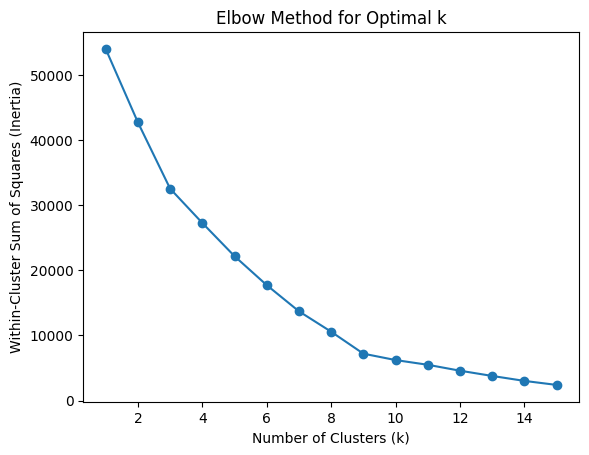

In [727]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'user_features_dummied'
# and the list of columns is as mentioned

# Select the categorical features for clustering
categorical_features = ['country_Others', 'country_country_1',
                         'city_code_Others', 'city_code_city_1', 'city_code_city_18',
                         'gender_Others', 'gender_female', 'gender_male',
                         'gender_skipped_by_user', 'age_(-1.001, 19.0]',
                         'age_(19.0, 22.0]', 'age_(22.0, 61.0]', 'college_code_code_present']

# Extract the selected features from the DataFrame
X = user_features_dummied[categorical_features]

# Standardize the features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose a range of clusters to try
k_values = range(1, 16)

# Initialize a list to store the inertia values
inertia_values = []

# Iterate through different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.show()

In [728]:
# Choose the optimal number of clusters based on the elbow method or your choice
optimal_clusters = 5

# Apply K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
user_features_dummied['cluster'] = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [729]:
user_features_dummied.cluster.value_counts()

0    2304
3     784
1     746
4     451
2     214
Name: cluster, dtype: int64

In [730]:
user_cluster_mapping = user_features_dummied[['user_code_new','cluster']]

In [731]:
ratings2 = ratings.merge(user_features_dummied[['user_code_new','cluster']], on='user_code_new',how='left')

In [732]:
ratings2.cluster.isnull().sum()

0

In [733]:
trending = ratings2.groupby(['cluster','poll_code_new'])[['event_score']].agg({'event_score':['sum','count']})
trending.columns = ["_".join(x) for x in trending.columns]
trending = trending[trending.event_score_count>20]

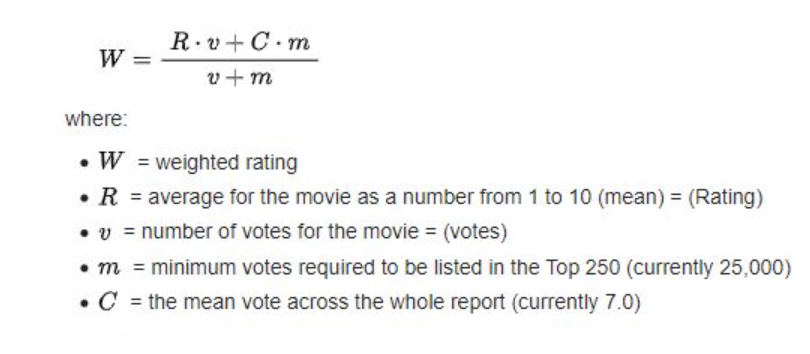

In [734]:
trending['weighted_score'] = (trending.event_score_sum + np.mean(trending.event_score_sum / trending.event_score_count)*20) / (trending.event_score_count + 20)

In [735]:
trending = trending.reset_index()
trending = trending.sort_values(['cluster','weighted_score'],ascending=[True,False])
trending10 = trending.groupby('cluster').head(10)
trending50 = trending.groupby('cluster').head(50)

In [736]:
result10 = ratings2[['user_code_new','cluster']].drop_duplicates().merge(trending10[['cluster','poll_code_new','weighted_score']],on='cluster')
result = ratings2[['user_code_new','cluster']].drop_duplicates().merge(trending50[['cluster','poll_code_new','weighted_score']],on='cluster')

In [737]:
result10 = result10.rename(columns={'weighted_score':'predicted'})
result = result.rename(columns={'weighted_score':'predicted'})

In [738]:
top_n = result.copy()

In [739]:
trend_top_10 = result10.copy()

##### CF - Metrics

In [740]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Trending Only'

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [741]:
result_dict['Trending Only'] = result

#### Hybrid : Content + Collaborative + Top10 Demographic Basis (Cold Start resolution)

In [742]:
print(trend_top_10.shape)
trend_top_10.sample(5)

(42040, 4)


,user_code_new,cluster,poll_code_new,predicted
4718,2551,3,191,0.908014
40730,4454,0,310,0.926154
7865,8,2,384,0.921451
34835,3357,0,518,0.891876
37320,3857,0,310,0.926154


In [743]:
print(cb_result.shape)
cb_result.sample(5)

(3418345, 3)


,user_code_new,poll_code_new,predicted
1187587,3013,246,0.666667
2519829,795,522,0.985945
2826035,2396,585,0.000000
90223,3194,19,0.000000
3008033,664,623,1.194219


In [744]:
print(svd_result.shape)
svd_result.sample(5)

(3537111, 3)


,user_code_new,poll_code_new,predicted
2841799,3105,234,0.705765
2893537,1866,879,0.629701
363000,1567,894,0.821289
3477918,3832,726,0.426482
143302,2672,367,0.838620


In [745]:
a = cb_result.rename(columns={'predicted':'pred_cb'})
b = svd_result.rename(columns={'predicted':'pred_svd'})

merged = a.merge(b,on=['user_code_new','poll_code_new'])

In [746]:
merged['predicted']=(merged.pred_cb*0.5 + merged.pred_svd*0.5)

In [747]:
merged = merged.sort_values(['user_code_new','predicted'],ascending=[True,False])

In [748]:
# merged.groupby('user_code_new').head(40)

In [749]:
trend_top_10_temp = trend_top_10[trend_top_10.user_code_new.isin(merged.user_code_new)]

In [750]:
hybrid_result = pd.concat([
    merged.groupby('user_code_new').head(40)[['user_code_new','poll_code_new','predicted']],
    trend_top_10_temp[['user_code_new','poll_code_new','predicted']]
],axis=0)

In [751]:
hybrid_result

,user_code_new,poll_code_new,predicted
0,1,108,1.171517
1,1,245,1.171517
3,1,332,1.171517
4,1,430,1.171517
5,1,625,1.171517
...,...,...,...
42035,4821,518,0.891876
42036,4821,557,0.889945
42037,4821,613,0.889799
42038,4821,293,0.888077


In [752]:
result = hybrid_result.copy()

##### CF - Metrics

In [753]:
# Example usage:
# Assuming you have DataFrames 'top_n' and 'test' with the specified columns

rmse_value = root_mean_squared_error_value(test,result)
mae_value = mean_absolute_error_value(test,result)
precision = precision_at_n(top_n, test, n=50)
recall = recall_at_n(top_n, test, n=50)
f1_score_value = f1_score_at_n(top_n, test, n=50)
mrr = mean_reciprocal_rank(top_n, test)
ndcg = ndcg_at_n(top_n, test, n=50)
map_value = mean_average_precision_at_n(top_n, test, n=50)

name = 'Hybrid : SVD + Content + Trending10)'

metrics_dict[name] = {
    'rmse_value'  :rmse_value ,
    'mae_value'  :mae_value ,
    'precision'  :precision ,
    'recall' :recall,
    'f1_score_value'  :f1_score_value ,
    'mrr' :mrr,
    'ndcg'  :ndcg ,
    'map_value'  :map_value
}

if print_flag :
  print(f"Mean Absolute Error: {mae_value:.4f}")
  print(f"Root Mean Squared Error: {rmse_value:.4f}")
  print(f"Precision at 50: {precision:.4f}")
  print(f"Recall at 50: {recall:.4f}")
  print(f"F1 Score at 50: {f1_score_value:.4f}")
  print(f"Mean Reciprocal Rank: {mrr:.4f}")
  print(f"NDCG at 50: {ndcg:.4f}")
  print(f"Mean Average Precision at 50: {map_value:.4f}")

In [754]:
result_dict[name] = result

### Final Result

In [807]:
final_result = pd.DataFrame(metrics_dict)

In [808]:
# final_result.to_csv("../result/metrics-appended-only-impression-poll-pearson.csv")

In [809]:
final_result

,Content Based,Collaborative Filtering UserBased,Collaborative Filtering ItemBased,Collaborative Filtering SVD (Surprise),Collaborative Filtering Manual (appended user_property for similarity),Trending Only,Hybrid : SVD + Content + Trending10)
rmse_value,0.491774,0.804398,0.827251,0.337364,0.803239,0.267480,0.321696
mae_value,0.298268,0.724170,0.741115,0.237696,0.723594,0.173580,0.174483
precision,0.007868,0.008128,0.000269,0.008674,0.008484,0.006422,0.006422
recall,0.145870,0.150702,0.004985,0.137511,0.157297,0.103536,0.103536
f1_score_value,0.014930,0.015425,0.000510,0.016319,0.016100,0.012095,0.012095
mrr,0.062544,0.216939,0.104894,0.112119,0.222363,0.119839,0.119839
ndcg,1.416700,1.424627,1.518573,1.409299,1.424445,1.471131,1.471131
map_value,0.106294,0.166654,0.180778,0.118393,0.170539,0.104840,0.104840


In [829]:
result_dict['Collaborative Filtering SVD (Surprise)'].to_csv("../best_model_recommendation_result.csv")

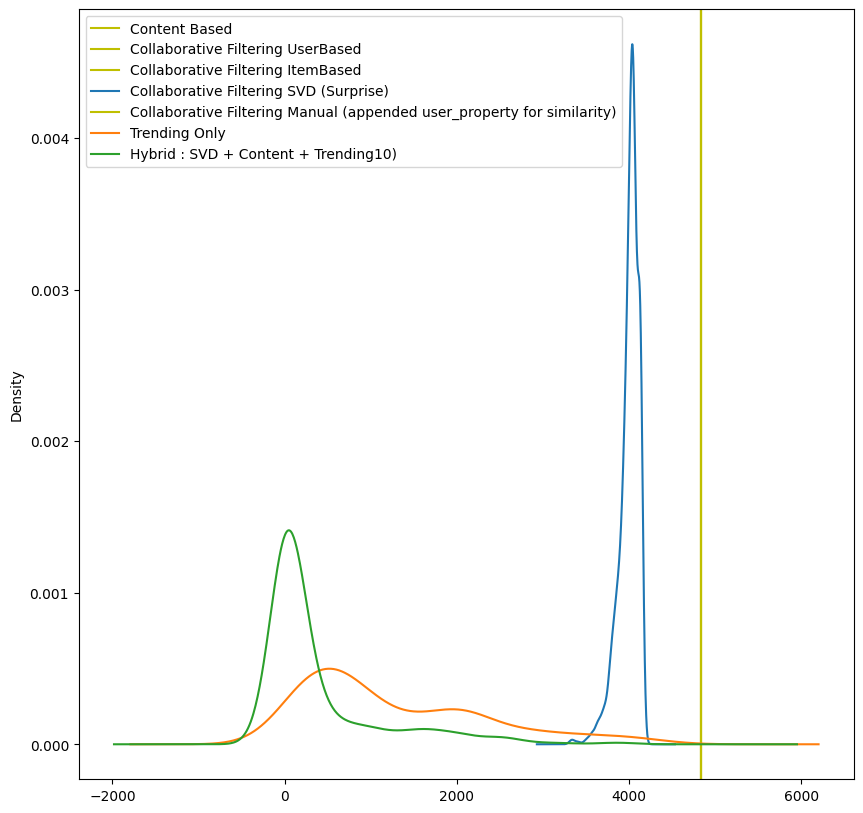

In [824]:
plt.figure(figsize=(10,10))
for i in result_dict.keys() :

  try:
    result_dict[i].groupby('poll_code_new').user_code_new.count().plot(kind='kde',label=i)


  except :
    plt.axvline(result_dict[i].poll_code_new.value_counts().values[0],label=i,color='y')

plt.legend()

In [766]:
result_dict['Collaborative Filtering UserBased '].groupby('poll_code_new').user_code_new.count()


poll_code_new
1      4835
2      4835
3      4835
4      4835
5      4835
       ... 
914    4835
915    4835
916    4835
917    4835
918    4835
Name: user_code_new, Length: 918, dtype: int64

<Axes: ylabel='Density'>

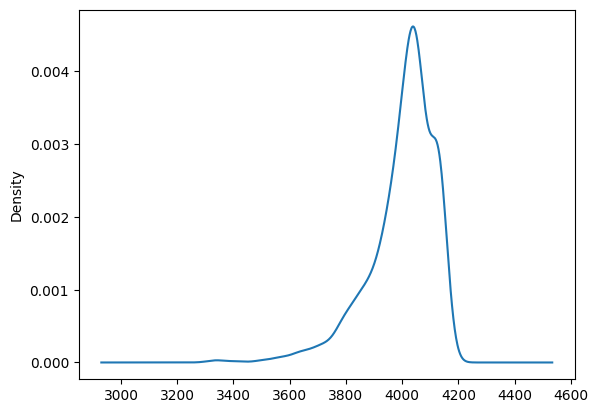

In [767]:
svd_result.groupby('poll_code_new').user_code_new.count().plot(kind='kde')